In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
!pip install -q --upgrade wandb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data Preprocessing

In [4]:
train_df = pd.read_csv('../input/agnews/train.csv',names=('label', 'title', 'description'))
test_df = pd.read_csv('../input/agnews/test.csv',names=('label', 'title', 'description'))

X_train = train_df['title'] + " " + train_df['description'] # Combine title and description for better accuracy 
y_train = train_df['label'].apply(lambda x: x-1).values # Class labels need to begin from 0

X_test = test_df['title'] + " " + test_df['description'] 
y_test = test_df['label'].apply(lambda x: x-1).values 

#Max Length of sentences in Train Dataset
max_length = X_train.map(lambda x: len(x.split())).max()


## Exploratory Data Analysis

In [5]:
train_df.isnull().sum()

label          0
title          0
description    0
dtype: int64

In [6]:
test_df.isnull().sum()

label          0
title          0
description    0
dtype: int64

In [7]:
#Checking label distrubtion
train_df.label.value_counts()

4    30000
3    30000
2    30000
1    30000
Name: label, dtype: int64

### Tokenization


Tokenization is a way of separating a piece of text into smaller units called tokens. 
Tokens can be either words, characters, or subwords. 


In [8]:
vocab_size = 15000 
embed_size = 64 

# Create tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train.values)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## Model

### LSTM - 
Standard Recurrent Neural Networks (RNNs) suffer from short-term memory due to a vanishing gradient problem that emerges when working with longer data sequences.

LSTM recurrent unit is much more complex than that of RNN, which improves learning but requires more computational resources.

1. **Hidden state & new inputs**: hidden state from a previous timestep (h_t-1) and the input at a current timestep (x_t) are combined before passing copies of it through various gates.

2. **Forget Gate**: This gate controls what information should be forgotten.

3. **Input Gate**: Helps to identify important elements that need to be added to the cell state.

4. **Update cell state**: First, the previous cell state (c_t-1) gets multiplied by the results of the forget gate. Then we add new information from [input gate × cell state candidate] to get the latest cell state (c_t).

5. **Update hidden state**:  The last part is to update the hidden state. The latest cell state (c_t) is passed through the tanh activation function and multiplied by the results of the output gate.

Finally, the latest cell state (c_t) and the hidden state (h_t) go back into the recurrent unit, and the process repeats at timestep t+1. The loop continues until we reach the end of the sequence.

### BiDirectional LSTM - 
A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction.

In [9]:
run = wandb.init(project='ag-news', config= {'_wandb_kernel': 'neuracort'})

wandb: Currently logged in as: sasadoe. Use `wandb login --relogin` to force relogin


In [11]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features and overfitting.
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #Softmax function is used as the activation function in the output layer of neural network models that predict a multinomial probability distribution.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 177, 64)           960000    
_________________________________________________________________
bidirectional (Bidirectional (None, 177, 256)          197632    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 177, 128)          164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

## Train Model

In [12]:
callbacks = [
    EarlyStopping(  
        monitor='val_accuracy',min_delta=1e-4,patience=5),
    ModelCheckpoint(
        filepath='weights.h5',monitor='val_accuracy', mode='max', save_best_only=True,save_weights_only=True
    ),
    WandbCallback()
]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [14]:
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy loss because Y is not one-hot encoded
              optimizer='adam', metrics=['accuracy']) 

history = model.fit(X_train, y_train, batch_size=256, validation_data=(X_test, y_test), epochs=40, callbacks=callbacks)

wandb.finish()

Epoch 1/40
469/469 [==============================] - 47s 89ms/step - loss: 0.0712 - accuracy: 0.9764 - val_loss: 0.3705 - val_accuracy: 0.9037

Epoch 00001: val_accuracy did not improve from 0.91237
Epoch 2/40
469/469 [==============================] - 41s 86ms/step - loss: 0.0458 - accuracy: 0.9854 - val_loss: 0.4463 - val_accuracy: 0.9026

Epoch 00002: val_accuracy did not improve from 0.91237
Epoch 3/40
469/469 [==============================] - 41s 86ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.5007 - val_accuracy: 0.9066

Epoch 00003: val_accuracy did not improve from 0.91237
Epoch 4/40
469/469 [==============================] - 40s 86ms/step - loss: 0.0316 - accuracy: 0.9910 - val_loss: 0.5249 - val_accuracy: 0.9014

Epoch 00004: val_accuracy did not improve from 0.91237
Epoch 5/40
469/469 [==============================] - 40s 86ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.5481 - val_accuracy: 0.9064

Epoch 00005: val_accuracy did not improve from 0.91237


accuracy,▁▄▅▆▇▇▇████████
epoch,▁▂▂▃▁▂▂▃▄▅▅▆▇▇█
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,██▇▇▄▄▅▃▅▃▆▃▁▅▄
val_loss,▁▁▁▂▃▄▅▅▅▆▇█▇██
accuracy,0.99465
best_epoch,2
best_val_loss,0.26806
epoch,10
loss,0.01953
val_accuracy,0.90434


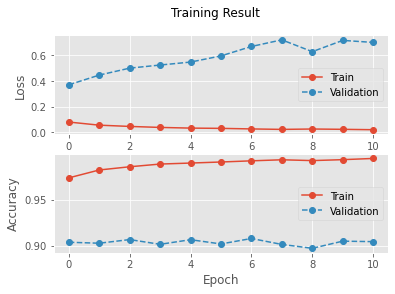

In [15]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Training Result')
ax1.plot(history.history['loss'], 'o-', label='Train')
ax1.plot(history.history['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], 'o-', label='Train')
ax2.plot(history.history['val_accuracy'], 'o--', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

## Load Weights with Best val Accuracy

In [16]:
model.load_weights('weights.h5')
model.save('model.hdf5')

## Model Evaluation

#### Confusion Matrix

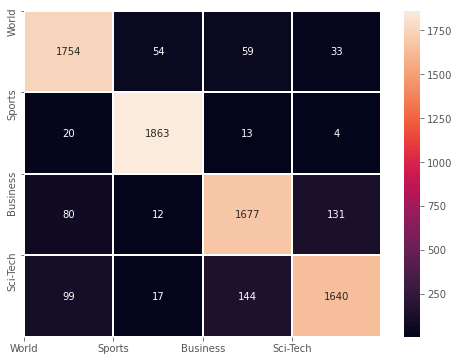

In [17]:
labels = ['World', 'Sports', 'Business', 'Sci-Tech']
preds = [np.argmax(i) for i in model.predict(X_test)]
matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
sn.heatmap(matrix, annot=True, linewidths=1, fmt='g')
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.show()

#### Recall, Precision and Accuracy

In [18]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.91
Precision of the model is 0.91
Accuracy of the model is 0.91
